Back to the main [Index](../index.ipynb) <a id="top"></a>

<div class="jumbotron">
  <h1 class="display-3">Third (basic) lesson with Abinit and AbiPy</h1>
  <p class="lead">Crystalline silicon.</p> 
  <hr class="my-4">
  <p>This lesson aims at showing you how to get the following physical properties, for an insulator:</p>
    
  <ul>
    <li>the total energy</li>
    <li>the lattice parameter</li>
    <li>the band structure (actually, the Kohn-Sham band structure) You will learn about the use of k-points, as well as the smearing of the plane-wave kinetic energy cut-off.</li>
  </ul>
  </div>

In [1]:
# Use this at the beginning of your script so that your code will be compatible with python3
from __future__ import print_function, division, unicode_literals

import numpy as np

import warnings 
warnings.filterwarnings("ignore")  # Ignore warnings

from abipy import abilab
abilab.enable_notebook() # This line tells AbiPy we are running inside a notebook

# This line tells the notebook to show plots inside of the notebook
%matplotlib notebook

## Computing the total energy of silicon at fixed number of k-points
[[back to top](#top)]

Our goal is to study the convergence of the total energy versus the number of k-points. 
So we start by defining a function that generates a `Flow` of SCF calculations for silicon
by looping over a predefined list of `ngkpt` values.
The structure is initialized from a CIF file, we use a norm-conserving pseudo provided by AbiPy and we fix
the values of other parameters e.g. the cutoff energy:

In [2]:
from lesson_base3 import build_ngkpt_flow
abilab.print_source(build_ngkpt_flow)

In [3]:
flow = build_ngkpt_flow(options=None)

In total, our `Flow` has 4 `GsTasks` and will be executed in the `flow_base3_ngkpt` directory.

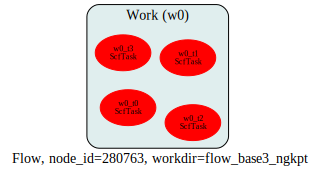

In [4]:
flow.get_graphviz()

This is the input of task w0_t0:

In [5]:
flow[0][0].input

<AbinitInput at 4598378848>

and these are the k-point samplings used in the four tasks:

In [6]:
for task in flow.iflat_tasks():
    print(task.pos_str, "uses ngkpt:", task.input["ngkpt"])

w0_t0 uses ngkpt: (2, 2, 2)
w0_t1 uses ngkpt: (4, 4, 4)
w0_t2 uses ngkpt: (6, 6, 6)
w0_t3 uses ngkpt: (8, 8, 8)


If you prefer, you can write the flow to file with `flow.build_and_pickle_dump()` and then run 
the calculation with `abirun.py` or, alternatively, we can use the files in the git repo and 
proceed with the analyisis of the data.

## Analysis of the results
[[back to top](#top)]

Also in this case, we assume the flow has been already executed and we start to analyze the data with GsrRobot.
Load all the GSR files presed in the flow_base3_ngkpt with:

In [7]:
robot_enekpt = abilab.GsrRobot.from_dir("flow_base3_ngkpt")
robot_enekpt

Label                     Relpath
------------------------  -----------------------------------------
w0/t0/outdata/out_GSR.nc  flow_base3_ngkpt/w0/t0/outdata/out_GSR.nc
w0/t1/outdata/out_GSR.nc  flow_base3_ngkpt/w0/t1/outdata/out_GSR.nc
w0/t2/outdata/out_GSR.nc  flow_base3_ngkpt/w0/t2/outdata/out_GSR.nc
w0/t3/outdata/out_GSR.nc  flow_base3_ngkpt/w0/t3/outdata/out_GSR.nc

The DataFrame contains several columns with output results and input parameters:

In [8]:
ene_table = robot_enekpt.get_dataframe()
ene_table.keys()

Index(['formula', 'natom', 'angle0', 'angle1', 'angle2', 'a', 'b', 'c',
       'volume', 'abispg_num', 'spglib_symb', 'spglib_num', 'energy',
       'pressure', 'max_force', 'ecut', 'pawecutdg', 'tsmear', 'nkpt',
       'nsppol', 'nspinor', 'nspden'],
      dtype='object')

We are mainly interested in the number of k-points `nkpt` and in the `energy` (given in eV) 
so we need to massage a bit the data to facilitate the post-processing:

In [9]:
# We are gonna plot f(nkpt) so let's sort the rows first.
ene_table.sort_values(by="nkpt", inplace=True) 

# Add a column with energies in Ha and another column with the difference wrt to the last point.
ene_table["energy_Ha"] = ene_table["energy"] * abilab.units.eV_to_Ha
ene_table["ediff_Ha"] = ene_table["energy_Ha"] - ene_table["energy_Ha"][-1]

and then print a subset of the columns with:

In [10]:
ene_table[["nkpt", "energy", "energy_Ha", "ediff_Ha"]]

,nkpt,energy,energy_Ha,ediff_Ha
w0/t0/outdata/out_GSR.nc,2,-241.251546,-8.865831,0.006242
w0/t1/outdata/out_GSR.nc,10,-241.417959,-8.871946,0.000126
w0/t2/outdata/out_GSR.nc,28,-241.421158,-8.872064,0.000009
w0/t3/outdata/out_GSR.nc,60,-241.421391,-8.872073,0.000000


If you don't like tables and prefer `matplotlib` plots, use:

<IPython.core.display.Javascript object>


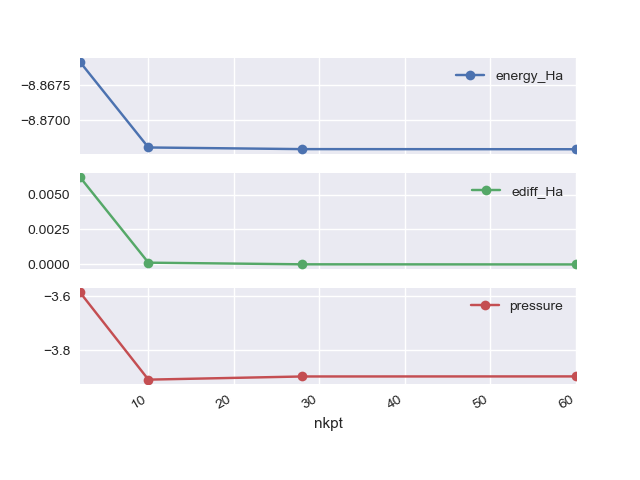

In [11]:
ene_table.plot(x="nkpt", y=["energy_Ha", "ediff_Ha", "pressure"], style="-o", subplots=True);

The difference between dataset 3 and dataset 4 is rather small. Even the dataset 2 gives an accuracy of about 0.0001 Ha
So, our converged value for the total energy, at fixed acell, fixed ecut, is -8.8726 Ha 

Now that we have learned a bit how to use pandas Dataframes, we can finally reveal
that the AbiPy robots *already* provide methods to perform this kind of convergence studies 
without having to manipulate pandas dataframes expliclty.
For example, we can perform the same analysis with:

<IPython.core.display.Javascript object>


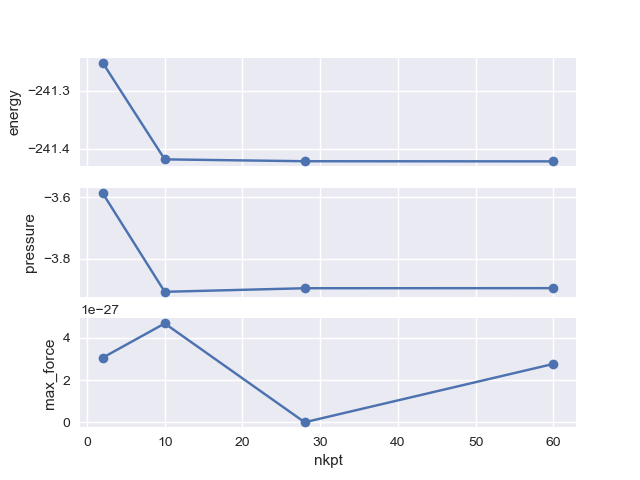

In [12]:
robot_enekpt.plot_gsr_convergence(sortby="nkpt");

<IPython.core.display.Javascript object>


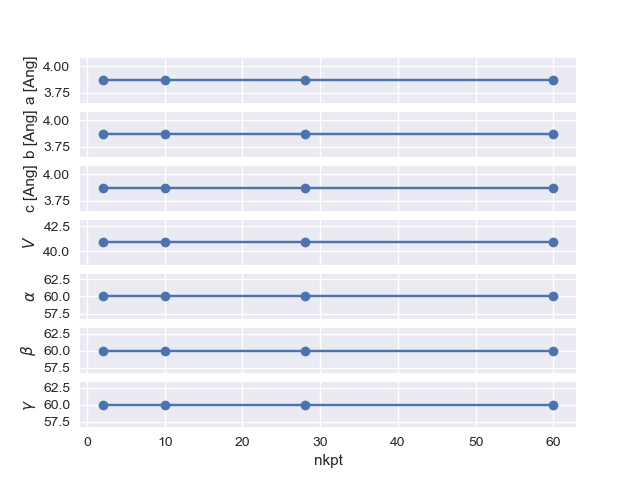

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [13]:
robot_enekpt.plot_lattice_convergence(sortby="nkpt");

## Determination of the lattice parameters
[[back to top](#top)]

In [14]:
from lesson_base3 import build_relax_flow
abilab.print_source(build_relax_flow)

In [15]:
#with abilab.abiopen("flow_base3_relax/w0/t1/run.abo") as abo:
#abo.plot?

This is our first structural relaxation with AbiPy and this gives us the opportunity to introduce the `HIST.nc`
file which stores the history of the relaxation (energies, forces, stresses, lattice parameters and atomic positions
at the different steps):

In [16]:
hist = abilab.abiopen("flow_base3_relax/w0/t1/outdata/out_HIST.nc")
print(hist)

================================= File Info =================================
Name: out_HIST.nc
Directory: /Users/gmatteo/git_repos/abitutorials/abitutorials/base3/flow_base3_relax/w0/t1/outdata
Size: 4.24 kb
Access Time: Thu Feb 15 18:21:11 2018
Modification Time: Wed Oct 11 00:28:35 2017
Change Time: Wed Oct 11 00:28:35 2017

============================= Initial Structure =============================
Full Formula (Si2)
Reduced Formula: Si
abc   :   3.866975   3.866975   3.866975
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c  cartesian_forces
---  ----  ----  ----  ----  --------------------------------------------------------------
  0  Si    0     0     0     [  4.10231606e-27  -5.80155101e-27  -3.31586260e-27] eV ang^-1
  1  Si    0.25  0.25  0.25  [ -4.10231606e-27   5.80155101e-27   3.31586260e-27] eV ang^-1

Number of relaxation steps performed: 4
============================== Final structure ==============================
Full Formula (Si2)
R

To plot the evolution of the most important physical quantities, use:

<IPython.core.display.Javascript object>


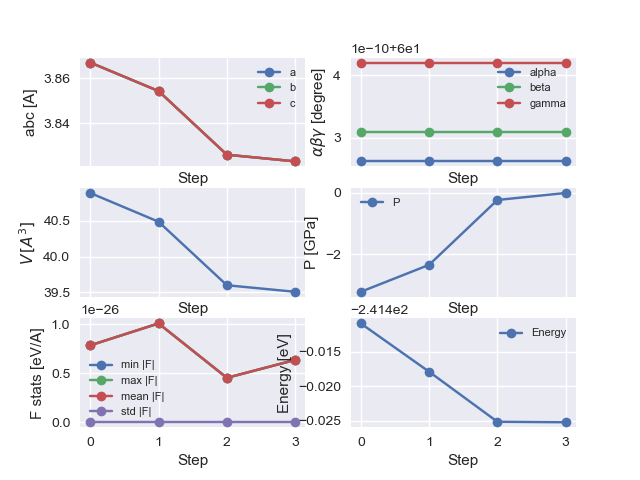

No handles with labels found to put in legend.


In [17]:
hist.plot();

The final structure is reported in the `HIST.nc` file as well as in the `GSR.nc`.
We can thus use the `GsrRobot` to compare the optimized lattices parameters as a function of the number of k-points `nkpt`:

In [18]:
with abilab.GsrRobot.from_dir("flow_base3_relax") as relkpt_robot:
    relax_table = relkpt_robot.get_dataframe().sort_values(by="nkpt")
    dfs = relkpt_robot.get_structure_dataframes()

In [19]:
relax_table

,formula,natom,angle0,angle1,angle2,a,b,c,volume,abispg_num,...,energy,pressure,max_force,ecut,pawecutdg,tsmear,nkpt,nsppol,nspinor,nspden
w0/t0/outdata/out_GSR.nc,Si2,2,60.0,60.0,60.0,3.829282,3.829282,3.829282,39.704254,227,...,-241.255628,-0.013259,1.913429e-27,8.0,-1.0,0.01,2,1,1,1
w0/t1/outdata/out_GSR.nc,Si2,2,60.0,60.0,60.0,3.822962,3.822962,3.822962,39.507981,227,...,-241.425215,-0.008757,6.356619e-27,8.0,-1.0,0.01,10,1,1,1


Plotting the energy, the lattice parameter `a` in Bohr and the pressure in `GPa` vs `nkpt` is really a piece of cake!

<IPython.core.display.Javascript object>


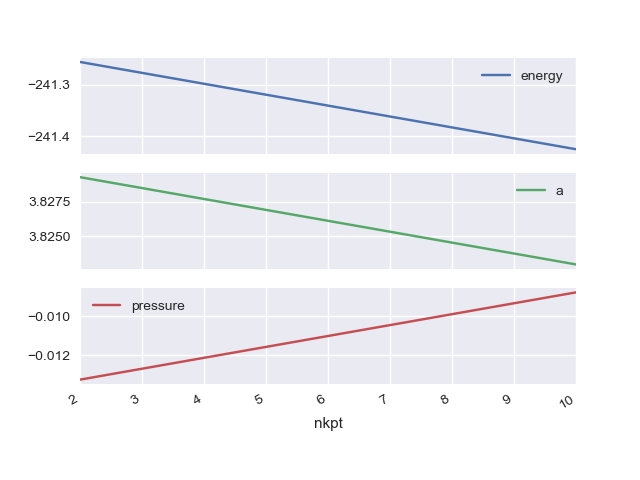

In [20]:
relax_table.plot(x="nkpt", y=["energy", "a", "pressure"], subplots=True);

<IPython.core.display.Javascript object>


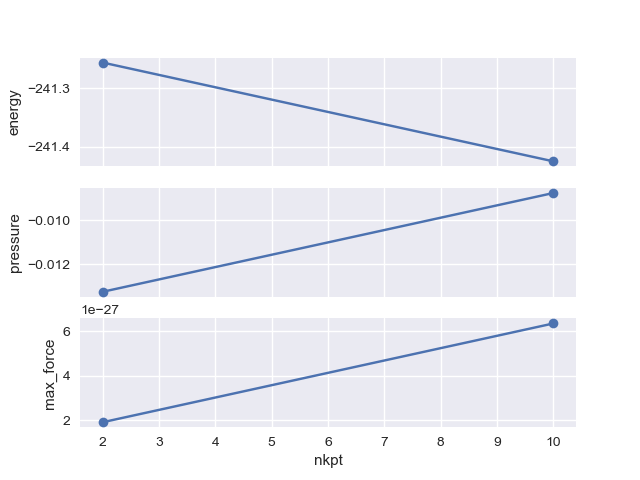

In [21]:
relkpt_robot.plot_gsr_convergence(sortby="nkpt");

<IPython.core.display.Javascript object>


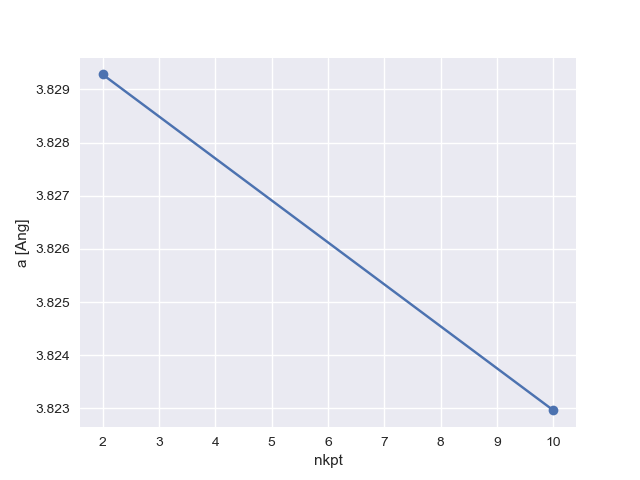

In [22]:
relkpt_robot.plot_lattice_convergence(what_list=["a"], sortby="nkpt");

We fix the parameters acell to the theoretical value of 3*10.216, and we fix also the grid of k points (the 4x4x4 FCC grid, equivalent to a 8x8x8 Monkhorst-pack grid)
We will ask for 8 bands (4 valence and 4 conduction).

## Computing the band structure
[[back to top](#top)]

A band structure can be computed by solving the Kohn-Sham equation for many different k points, along different lines of the Brillouin zone.
The potential that enters the Kohn-Sham must be derived from a previous self- consistent calculation, and will not vary during the scan of different k-point lines.

Suppose that you want to make a L-Gamma-X-(U-)Gamma circuit, with 10, 12 and 17 divisions for each line (each segment has a different length in reciprocal space, and these divisions give approximately the same distance between points along a line).
The circuit will be obtained easily by the following choice of segment end points.

In [23]:
from lesson_base3 import build_ebands_flow
abilab.print_source(build_ebands_flow)

The `Flow` consists of a single `Workflow` with two `Tasks` (`ScfTask` on k-mesh + `NscfTask` on the k-path).
Let's extract the band structure from the `GSR.nc` file produced by the `NscfTask` with `abiopen`:

In [24]:
with abilab.abiopen("flow_base3_ebands/w0/t1/outdata/out_GSR.nc") as gsr:
    ebands_kpath = gsr.ebands

and plot it with:

<IPython.core.display.Javascript object>


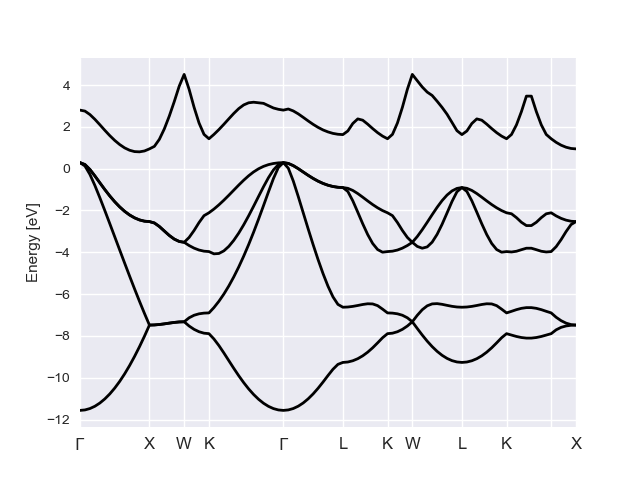

In [25]:
ebands_kpath.plot();

The width of the valence band is 12.09 eV, the lowest unoccupied state at X is 0.594 eV higher than the top of the valence band, at Gamma. The Si is described as an indirect band gap material (this is correct), with a band-gap of about 0.594 eV (this is quantitatively quite wrong: the experimental value 1.17 eV is at 25 degree Celsius). The minimum of the conduction band is even slightly displaced with respect to X, see kpt # 21. 

This underestimation of the band gap is well-known (the famous DFT band-gap problem). 
In order to obtain correct band gaps, you need to go beyond the Kohn-Sham Density Functional Theory: 
use the $GW$ approximation. 
This is described in the first lesson on the $GW$ approximation.

We can also plot the k-path in the Brillouin zone with:

<IPython.core.display.Javascript object>


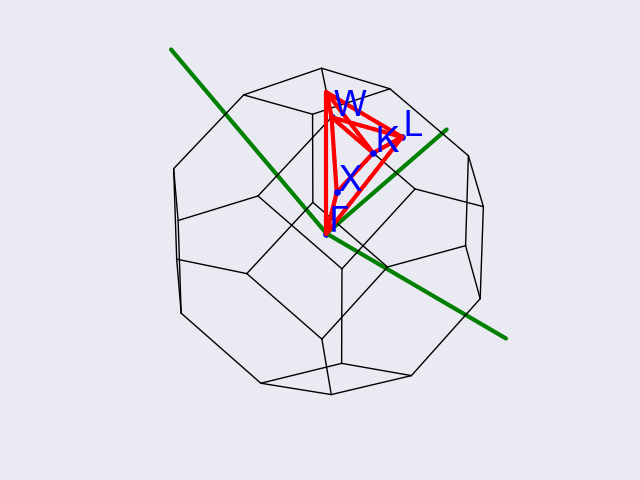

In [26]:
ebands_kpath.kpoints.plot();

The `GSR` file produced by the first task contains energies on a homogeneous k-mesh.
We can therefore compute the DOS by invoking the `get_edos` method of `ElectronBands`:

In [27]:
with abilab.abiopen("flow_base3_ebands/w0/t0/outdata/out_GSR.nc") as gsr:
    ebands_kmesh = gsr.ebands
    
edos = ebands_kmesh.get_edos()

and plot the DOS with:

<IPython.core.display.Javascript object>


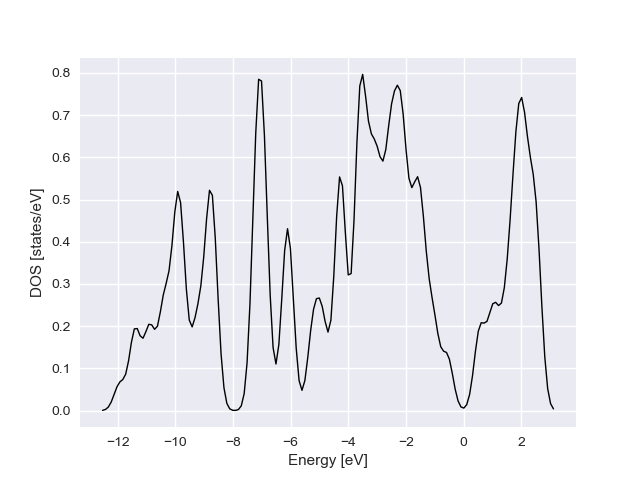

In [28]:
edos.plot();

where the zero of the energy axis is set to the Fermi level $\epsilon_F$ obtained by solving:
    
$$\int_{-\infty}^{\epsilon_F} g(\epsilon)\,d\epsilon = N$$

for $\epsilon_F$ with $N$ the number of electrons per unit cell.

When I was a student, I had to spent a lot of time to extract data from text files and make nice pictures 
of the electronic band dispersion with a second panel for the DOS.
Now, thanks to AbiPy, it's possible to produce such plots with a single line:

<IPython.core.display.Javascript object>


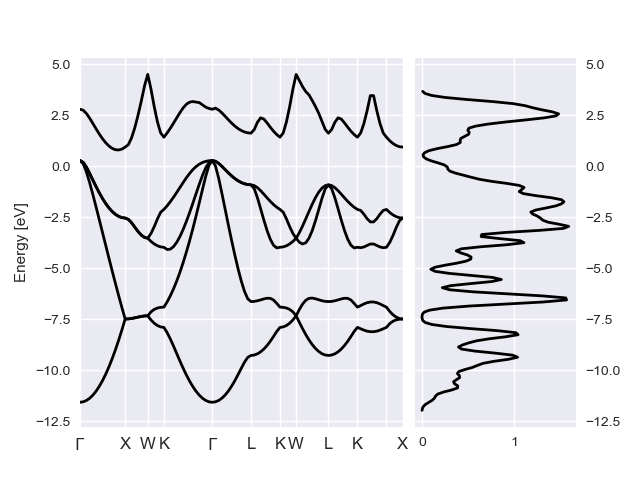

In [29]:
ebands_kpath.plot_with_edos(edos);

Stop reading now and look at the bands + DOS plot carefully. 
Do you see anything weird?

<IPython.core.display.Javascript object>


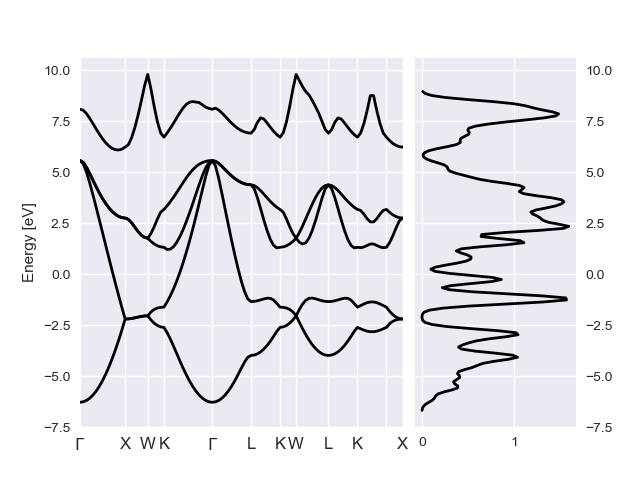

In [30]:
ebands_kpath.plot_with_edos(edos, e0=0);

In [31]:
print(ebands_kmesh.fermie, ebands_kpath.fermie, edos.fermie)

5.280063055928883 5.280063055928883 5.83829326559


Back to the main [Index](../index.ipynb)